# Table of Contents:

**1. [Problem Definition](#id1)** <br>
**2. [Get the Data (Collect / Obtain)](#id2)** <br>
**3. [Load the Dataset](#id3)** <br>
**4. [Data Pre-processing](#id4)** <br>
**5. [Model](#id5)** <br>
**6. [Visualization and Analysis of Results](#id6)** <br>
**7. [Submittion](#id7)** <br>
**8. [References](#ref)** <br>

<a id="id1"></a> <br> 
# **1. Problem Definition:** 

This challenge aims to predict interactions between atoms. The main task is develop an algorithm that can predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant)<br>

In this competition, you will be predicting the scalar_coupling_constant between atom pairs in molecules, given the two atom types (e.g., C and H), the coupling type (e.g., 2JHC), and any features you are able to create from the molecule structure (xyz) files.

**Data**
* **train.csv** - the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates, the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (**scalar_coupling_constant**) is the scalar coupling constant that we want to be able to predict
* **test.csv** - the test set; same info as train, without the target variable
* **sample_submission.csv** - a sample submission file in the correct format
* **structures.csv** - this file contains the same information as the individual xyz structure files, but in a single file

**Additional Data**<br>
*NOTE: additional data is provided for the molecules in Train only!*
* **scalar_coupling_contributions.csv** - The scalar coupling constants in train.csv are a sum of four terms. The first column (**molecule_name**) are the name of the molecule, the second (**atom_index_0**) and third column (**atom_index_1**) are the atom indices of the atom-pair, the fourth column indicates the **type** of coupling, the fifth column (**fc**) is the Fermi Contact contribution, the sixth column (**sd**) is the Spin-dipolar contribution, the seventh column (**pso**) is the Paramagnetic spin-orbit contribution and the eighth column (**dso**) is the Diamagnetic spin-orbit contribution.



<a id="id2"></a> <br> 
# **2. Get the Data (Collect / Obtain):** 

## All imports used in this kernel

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product
from datetime import datetime

## All function used in this kernel

In [2]:
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )  

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    
    
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, 
                           plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, 
                           n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'], verbose=verbose, 
                      early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, 
                              verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], 
                                      **params, loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, 
                               n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'], verbose=verbose, 
                      early_stopping_rounds=early_stopping_rounds)
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, 
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, 
                                       eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params, 
                                       loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

def get_avg_stdev(X_short):
    sum_stdev = 0
    for i, t in enumerate(X_short['type'].unique()):
        sum_stdev += X_short.loc[X_short['type'] == t].std()['target']

    avg_stdev = sum_stdev / len(X_short['type'].unique())
    print(f'avg standard deviation: {avg_stdev}')
    return avg_stdev

<a id="id3"></a> <br> 
# **3. Load the Dataset** 

Let's load all necessary datasets

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')
structures = pd.read_csv('data/structures.csv')
scalar_coupling_contributions = pd.read_csv('data/scalar_coupling_contributions.csv')
acsf = pd.read_csv('data/external_data/structure_with_acsf.csv')

print('Train dataset shape is -> rows: {} cols:{}'.format(train.shape[0],train.shape[1]))
print('Test dataset shape is  -> rows: {} cols:{}'.format(test.shape[0],test.shape[1]))
print('Sub dataset shape is  -> rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))
print('Structures dataset shape is  -> rows: {} cols:{}'.format(structures.shape[0],structures.shape[1]))
print('Scalar_coupling_contributions dataset shape is  -> rows: {} cols:{}' \
      .format(scalar_coupling_contributions.shape[0], scalar_coupling_contributions.shape[1]))
print('structure_acsf dataset shape is  -> rows: {} cols:{}'.format(acsf.shape[0], acsf.shape[1]))

Train dataset shape is -> rows: 4658147 cols:6
Test dataset shape is  -> rows: 2505542 cols:5
Sub dataset shape is  -> rows: 2505542 cols:2
Structures dataset shape is  -> rows: 2358657 cols:6
Scalar_coupling_contributions dataset shape is  -> rows: 4658147 cols:8
structure_acsf dataset shape is  -> rows: 2358657 cols:132


## Load extra features

In [4]:
train_bonds   = pd.read_csv('data/external_data/train_bonds.csv')
train_charges = pd.read_csv('data/external_data/train_charges.csv')
#train_cycles  = pd.read_csv('data/external_data/train_cycles.csv')

test_bonds   = pd.read_csv('data/external_data/test_bonds.csv')
test_charges = pd.read_csv('data/external_data/test_charges.csv')
#test_cycles  = pd.read_csv('data/external_data/test_cycles.csv')

print('train_bonds dataset shape is -> rows: {} cols:{}'.format(train_bonds.shape[0],train_bonds.shape[1]))
print('train_charges dataset shape is -> rows: {} cols:{}'.format(train_charges.shape[0],train_charges.shape[1]))
#print('train_cycles dataset shape is -> rows: {} cols:{}'.format(train_cycles.shape[0],train_cycles.shape[1]))
print('test_bonds dataset shape is -> rows: {} cols:{}'.format(test_bonds.shape[0],test_bonds.shape[1]))
print('test_charges dataset shape is -> rows: {} cols:{}'.format(test_charges.shape[0],test_charges.shape[1]))
#print('test_cycles dataset shape is -> rows: {} cols:{}'.format(test_cycles.shape[0],test_cycles.shape[1]))

train_bonds dataset shape is -> rows: 1586228 cols:7
train_charges dataset shape is -> rows: 1533537 cols:3
test_bonds dataset shape is -> rows: 853433 cols:7
test_charges dataset shape is -> rows: 825120 cols:3


For an fast model/feature evaluation, get only 1% of dataset. Final submission must remove/coments this code

In [5]:
'''
size = round(0.01*train.shape[0])
train = train[:size]
test = test[:size]
sub = sub[:size]
structures = structures[:size]
acsf = acsf[:size]
scalar_coupling_contributions = scalar_coupling_contributions[:size]
'''

In [6]:
print('Train dataset shape is now rows: {} cols:{}'.format(train.shape[0],train.shape[1]))
print('Test dataset shape is now rows: {} cols:{}'.format(test.shape[0],test.shape[1]))
print('Sub dataset shape is now rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))
print('Structures dataset shape is now rows: {} cols:{}'.format(structures.shape[0],structures.shape[1]))
print('Scalar_coupling_contributions dataset shape is now rows: {} cols:{}'
                                                        .format(scalar_coupling_contributions.shape[0],
                                                         scalar_coupling_contributions.shape[1]))

Train dataset shape is now rows: 46581 cols:6
Test dataset shape is now rows: 46581 cols:5
Sub dataset shape is now rows: 46581 cols:2
Structures dataset shape is now rows: 46581 cols:6
Scalar_coupling_contributions dataset shape is now rows: 46581 cols:8


## take a look at train/test and extra feature datasets

In [7]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [8]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [9]:
train_bonds.head()

,molecule_name,atom_index_0,atom_index_1,nbond,L2dist,error,bond_type
0,dsgdb9nsd_000001,0,1,1.0,1.091953059611900,0,1.0CH
1,dsgdb9nsd_000001,0,2,1.0,1.091951618581363,0,1.0CH
2,dsgdb9nsd_000001,0,3,1.0,1.091946379133103,0,1.0CH
3,dsgdb9nsd_000001,0,4,1.0,1.091947541112026,0,1.0CH
4,dsgdb9nsd_000002,0,1,1.0,1.017190026633150,0,1.0HN


In [10]:
train_charges.head()

,molecule_name,atom_index,charge
0,dsgdb9nsd_000001,0,0.0
1,dsgdb9nsd_000001,1,0.0
2,dsgdb9nsd_000001,2,0.0
3,dsgdb9nsd_000001,3,0.0
4,dsgdb9nsd_000001,4,0.0


In [11]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


### finding the best correlation in scalar coupling contributions (but it's not in test dataset)

In [12]:
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400000000005,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700000000001,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500000000001,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900000000000,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022199999999998,0.254585,1.25861,0.272013


`train['scalar_coupling_constant'] and scalar_coupling_contributions['fc']` quite similar

In [13]:
pd.concat(objs=[train['scalar_coupling_constant'],scalar_coupling_contributions['fc'] ],axis=1)[:5]

,scalar_coupling_constant,fc
0,84.807599999999994,83.022400000000005
1,-11.257000000000000,-11.034700000000001
2,-11.254799999999999,-11.032500000000001
3,-11.254300000000001,-11.031900000000000
4,84.807400000000001,83.022199999999998


one idea I found in the kaggle discussions:

- train a model to predict `fc` feature;
- add this feature to train and test and train the same model to compare performance;
- train a better model;

<a id="id4"></a> <br> 
# **4. Data Pre-processing** 

## Feature generation for structures

I use this great kernel to get x,y,z position. https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [14]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

#display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


### Chemical Bond Calculation

In [15]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 29

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
bond_lengths_median = [ np.median(x) for x in bond_lengths]
bond_lengths_std = [ np.std(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean,
             'bond_lengths_std':bond_lengths_std, 'bond_lengths_median': bond_lengths_median }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
#display(structures.head(20))

Calculating bonds



Counting and condensing bonds


structures_acsf.csv contains mulliken charges but also the structures columns  

In [16]:
acsf.drop(['Unnamed: 0', 'atom', 'x', 'y', 'z'], axis=1, inplace=True)

In [17]:
acsf.head()

,molecule_name,atom_index,feat_acsf_g1_H_10.0,"feat_acsf_g2_H_[1, 2]","feat_acsf_g2_H_[0.1, 2]","feat_acsf_g2_H_[0.01, 2]","feat_acsf_g2_H_[1, 6]","feat_acsf_g2_H_[0.1, 6]","feat_acsf_g2_H_[0.01, 6]",feat_acsf_g1_C_10.0,"feat_acsf_g2_C_[1, 2]","feat_acsf_g2_C_[0.1, 2]","feat_acsf_g2_C_[0.01, 2]","feat_acsf_g2_C_[1, 6]","feat_acsf_g2_C_[0.1, 6]","feat_acsf_g2_C_[0.01, 6]",feat_acsf_g1_N_10.0,"feat_acsf_g2_N_[1, 2]","feat_acsf_g2_N_[0.1, 2]","feat_acsf_g2_N_[0.01, 2]","feat_acsf_g2_N_[1, 6]","feat_acsf_g2_N_[0.1, 6]","feat_acsf_g2_N_[0.01, 6]",feat_acsf_g1_O_10.0,"feat_acsf_g2_O_[1, 2]","feat_acsf_g2_O_[0.1, 2]","feat_acsf_g2_O_[0.01, 2]","feat_acsf_g2_O_[1, 6]","feat_acsf_g2_O_[0.1, 6]","feat_acsf_g2_O_[0.01, 6]",feat_acsf_g1_F_10.0,"feat_acsf_g2_F_[1, 2]","feat_acsf_g2_F_[0.1, 2]","feat_acsf_g2_F_[0.01, 2]","feat_acsf_g2_F_[1, 6]","feat_acsf_g2_F_[0.1, 6]","feat_acsf_g2_F_[0.01, 6]","feat_acsf_g4_H_H_[1, 4, 1]","feat_acsf_g4_H_H_[0.1, 4, 1]","feat_acsf_g4_H_H_[0.01, 4, 1]","feat_acsf_g4_H_H_[1, 4, -1]","feat_acsf_g4_H_H_[0.1, 4, -1]","feat_acsf_g4_H_H_[0.01, 4, -1]","feat_acsf_g4_C_H_[1, 4, 1]","feat_acsf_g4_C_H_[0.1, 4, 1]","feat_acsf_g4_C_H_[0.01, 4, 1]","feat_acsf_g4_C_H_[1, 4, -1]","feat_acsf_g4_C_H_[0.1, 4, -1]","feat_acsf_g4_C_H_[0.01, 4, -1]","feat_acsf_g4_C_C_[1, 4, 1]","feat_acsf_g4_C_C_[0.1, 4, 1]","feat_acsf_g4_C_C_[0.01, 4, 1]","feat_acsf_g4_C_C_[1, 4, -1]","feat_acsf_g4_C_C_[0.1, 4, -1]","feat_acsf_g4_C_C_[0.01, 4, -1]","feat_acsf_g4_N_H_[1, 4, 1]","feat_acsf_g4_N_H_[0.1, 4, 1]","feat_acsf_g4_N_H_[0.01, 4, 1]","feat_acsf_g4_N_H_[1, 4, -1]","feat_acsf_g4_N_H_[0.1, 4, -1]","feat_acsf_g4_N_H_[0.01, 4, -1]","feat_acsf_g4_N_C_[1, 4, 1]","feat_acsf_g4_N_C_[0.1, 4, 1]","feat_acsf_g4_N_C_[0.01, 4, 1]","feat_acsf_g4_N_C_[1, 4, -1]","feat_acsf_g4_N_C_[0.1, 4, -1]","feat_acsf_g4_N_C_[0.01, 4, -1]","feat_acsf_g4_N_N_[1, 4, 1]","feat_acsf_g4_N_N_[0.1, 4, 1]","feat_acsf_g4_N_N_[0.01, 4, 1]","feat_acsf_g4_N_N_[1, 4, -1]","feat_acsf_g4_N_N_[0.1, 4, -1]","feat_acsf_g4_N_N_[0.01, 4, -1]","feat_acsf_g4_O_H_[1, 4, 1]","feat_acsf_g4_O_H_[0.1, 4, 1]","feat_acsf_g4_O_H_[0.01, 4, 1]","feat_acsf_g4_O_H_[1, 4, -1]","feat_acsf_g4_O_H_[0.1, 4, -1]","feat_acsf_g4_O_H_[0.01, 4, -1]","feat_acsf_g4_O_C_[1, 4, 1]","feat_acsf_g4_O_C_[0.1, 4, 1]","feat_acsf_g4_O_C_[0.01, 4, 1]","feat_acsf_g4_O_C_[1, 4, -1]","feat_acsf_g4_O_C_[0.1, 4, -1]","feat_acsf_g4_O_C_[0.01, 4, -1]","feat_acsf_g4_O_N_[1, 4, 1]","feat_acsf_g4_O_N_[0.1, 4, 1]","feat_acsf_g4_O_N_[0.01, 4, 1]","feat_acsf_g4_O_N_[1, 4, -1]","feat_acsf_g4_O_N_[0.1, 4, -1]","feat_acsf_g4_O_N_[0.01, 4, -1]","feat_acsf_g4_O_O_[1, 4, 1]","feat_acsf_g4_O_O_[0.1, 4, 1]","feat_acsf_g4_O_O_[0.01, 4, 1]","feat_acsf_g4_O_O_[1, 4, -1]","feat_acsf_g4_O_O_[0.1, 4, -1]","feat_acsf_g4_O_O_[0.01, 4, -1]","feat_acsf_g4_F_H_[1, 4, 1]","feat_acsf_g4_F_H_[0.1, 4, 1]","feat_acsf_g4_F_H_[0.01, 4, 1]","feat_acsf_g4_F_H_[1, 4, -1]","feat_acsf_g4_F_H_[0.1, 4, -1]","feat_acsf_g4_F_H_[0.01, 4, -1]","feat_acsf_g4_F_C_[1, 4, 1]","feat_acsf_g4_F_C_[0.1, 4, 1]","feat_acsf_g4_F_C_[0.01, 4, 1]","feat_acsf_g4_F_C_[1, 4, -1]","feat_acsf_g4_F_C_[0.1, 4, -1]","feat_acsf_g4_F_C_[0.01, 4, -1]","feat_acsf_g4_F_N_[1, 4, 1]","feat_acsf_g4_F_N_[0.1, 4, 1]","feat_acsf_g4_F_N_[0.01, 4, 1]","feat_acsf_g4_F_N_[1, 4, -1]","feat_acsf_g4_F_N_[0.1, 4, -1]","feat_acsf_g4_F_N_[0.01, 4, -1]","feat_acsf_g4_F_O_[1, 4, 1]","feat_acsf_g4_F_O_[0.1, 4, 1]","feat_acsf_g4_F_O_[0.01, 4, 1]","feat_acsf_g4_F_O_[1, 4, -1]","feat_acsf_g4_F_O_[0.1, 4, -1]","feat_acsf_g4_F_O_[0.01, 4, -1]","feat_acsf_g4_F_F_[1, 4, 1]","feat_acsf_g4_F_F_[0.1, 4, 1]","feat_acsf_g4_F_F_[0.01, 4, 1]","feat_acsf_g4_F_F_[1, 4, -1]","feat_acsf_g4_F_F_[0.1, 4, -1]","feat_acsf_g4_F_F_[0.01, 4, -1]"
0,dsgdb9nsd_000001,0,3.883468866348267,1.702628612518310,3.576101541519165,3.851579189300537,0.000000000134128,0.349180281162262,3.052128314971924,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [18]:
structures = reduce_mem_usage(structures)
#acsf = reduce_mem_usage(acsf)

Mem. usage decreased to  3.64 Mb (14.6% reduction)


In [19]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  1.33 Mb (37.5% reduction)
Mem. usage decreased to  0.98 Mb (45.0% reduction)


## merging dataframes

### extra features into structures first

In [20]:
charges = pd.concat([train_charges, test_charges])

structures = pd.merge(structures, charges, how = 'left',
                           left_on  = ['molecule_name', 'atom_index'],
                           right_on = ['molecule_name',  'atom_index'])

In [21]:
len(structures[structures.charge != 0]) 

6

## then everything into train and test dataframes

train_bonds.csv and test_bonds.csv contain information about possible bonds between atoms

In [22]:
bonds = pd.concat([train_bonds, test_bonds])

bonds = bonds.rename(columns={'atom_index_0': 'atom_index_1',
                              'atom_index_1': 'atom_index_0'}) 

In [23]:
def map_bonds(df):
    df = pd.merge(df, bonds, how = 'left',
              left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1'],
              right_on = ['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df
    
train = map_bonds(train)
test = map_bonds(test)

In [24]:
len(train[pd.notna(train.L2dist)]), len(test[pd.notna(test.L2dist)])

(8448, 8199)

In [25]:
def map_atom_info(df, atom_idx):
    old_cols = df.columns
    
    df = pd.merge(df, acsf, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    print(f'merged dataframe with acsf on atom_idx: {atom_idx}')
    
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    print(f'merged dataframe with structures on atom_idx: {atom_idx}')
    
    diff_cols = df.columns.difference(old_cols)
    
    for col in diff_cols:
        df = df.rename(columns={col: f'{col}_{atom_idx}'}) 
    
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)
train.drop(['atom_index_x_0', 'atom_index_x_1', 'atom_index_y_0', 'atom_index_y_1'], axis=1, inplace=True)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)
test.drop(['atom_index_x_0', 'atom_index_x_1', 'atom_index_y_0', 'atom_index_y_1'], axis=1, inplace=True)

merged dataframe with acsf on atom_idx: 0
merged dataframe with structures on atom_idx: 0
merged dataframe with acsf on atom_idx: 1
merged dataframe with structures on atom_idx: 1
merged dataframe with acsf on atom_idx: 0
merged dataframe with structures on atom_idx: 0
merged dataframe with acsf on atom_idx: 1
merged dataframe with structures on atom_idx: 1


In [26]:
del structures, acsf
gc.collect()

70

In [27]:
#TODO merge angles and distances

In [28]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

the scalar coupling constants in scalar_coupling_contributions.csv are a sum of four terms. 
```
* fc is the Fermi Contact contribution
* sd is the Spin-dipolar contribution
* pso is the Paramagnetic spin-orbit contribution
* dso is the Diamagnetic spin-orbit contribution. 
```

In [29]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

### sanity check after merge

In [30]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nbond,L2dist,error,bond_type,feat_acsf_g1_H_10.0_0,"feat_acsf_g2_H_[1, 2]_0","feat_acsf_g2_H_[0.1, 2]_0","feat_acsf_g2_H_[0.01, 2]_0","feat_acsf_g2_H_[1, 6]_0","feat_acsf_g2_H_[0.1, 6]_0","feat_acsf_g2_H_[0.01, 6]_0",feat_acsf_g1_C_10.0_0,"feat_acsf_g2_C_[1, 2]_0","feat_acsf_g2_C_[0.1, 2]_0","feat_acsf_g2_C_[0.01, 2]_0","feat_acsf_g2_C_[1, 6]_0","feat_acsf_g2_C_[0.1, 6]_0","feat_acsf_g2_C_[0.01, 6]_0",feat_acsf_g1_N_10.0_0,"feat_acsf_g2_N_[1, 2]_0","feat_acsf_g2_N_[0.1, 2]_0","feat_acsf_g2_N_[0.01, 2]_0","feat_acsf_g2_N_[1, 6]_0","feat_acsf_g2_N_[0.1, 6]_0","feat_acsf_g2_N_[0.01, 6]_0",feat_acsf_g1_O_10.0_0,"feat_acsf_g2_O_[1, 2]_0","feat_acsf_g2_O_[0.1, 2]_0","feat_acsf_g2_O_[0.01, 2]_0","feat_acsf_g2_O_[1, 6]_0","feat_acsf_g2_O_[0.1, 6]_0","feat_acsf_g2_O_[0.01, 6]_0",feat_acsf_g1_F_10.0_0,"feat_acsf_g2_F_[1, 2]_0","feat_acsf_g2_F_[0.1, 2]_0","feat_acsf_g2_F_[0.01, 2]_0","feat_acsf_g2_F_[1, 6]_0","feat_acsf_g2_F_[0.1, 6]_0","feat_acsf_g2_F_[0.01, 6]_0","feat_acsf_g4_H_H_[1, 4, 1]_0","feat_acsf_g4_H_H_[0.1, 4, 1]_0","feat_acsf_g4_H_H_[0.01, 4, 1]_0","feat_acsf_g4_H_H_[1, 4, -1]_0","feat_acsf_g4_H_H_[0.1, 4, -1]_0","feat_acsf_g4_H_H_[0.01, 4, -1]_0","feat_acsf_g4_C_H_[1, 4, 1]_0","feat_acsf_g4_C_H_[0.1, 4, 1]_0","feat_acsf_g4_C_H_[0.01, 4, 1]_0","feat_acsf_g4_C_H_[1, 4, -1]_0","feat_acsf_g4_C_H_[0.1, 4, -1]_0","feat_acsf_g4_C_H_[0.01, 4, -1]_0","feat_acsf_g4_C_C_[1, 4, 1]_0","feat_acsf_g4_C_C_[0.1, 4, 1]_0","feat_acsf_g4_C_C_[0.01, 4, 1]_0","feat_acsf_g4_C_C_[1, 4, -1]_0","feat_acsf_g4_C_C_[0.1, 4, -1]_0","feat_acsf_g4_C_C_[0.01, 4, -1]_0","feat_acsf_g4_N_H_[1, 4, 1]_0","feat_acsf_g4_N_H_[0.1, 4, 1]_0","feat_acsf_g4_N_H_[0.01, 4, 1]_0","feat_acsf_g4_N_H_[1, 4, -1]_0","feat_acsf_g4_N_H_[0.1, 4, -1]_0","feat_acsf_g4_N_H_[0.01, 4, -1]_0","feat_acsf_g4_N_C_[1, 4, 1]_0","feat_acsf_g4_N_C_[0.1, 4, 1]_0","feat_acsf_g4_N_C_[0.01, 4, 1]_0","feat_acsf_g4_N_C_[1, 4, -1]_0","feat_acsf_g4_N_C_[0.1, 4, -1]_0","feat_acsf_g4_N_C_[0.01, 4, -1]_0","feat_acsf_g4_N_N_[1, 4, 1]_0","feat_acsf_g4_N_N_[0.1, 4, 1]_0","feat_acsf_g4_N_N_[0.01, 4, 1]_0","feat_acsf_g4_N_N_[1, 4, -1]_0","feat_acsf_g4_N_N_[0.1, 4, -1]_0","feat_acsf_g4_N_N_[0.01, 4, -1]_0","feat_acsf_g4_O_H_[1, 4, 1]_0","feat_acsf_g4_O_H_[0.1, 4, 1]_0","feat_acsf_g4_O_H_[0.01, 4, 1]_0","feat_acsf_g4_O_H_[1, 4, -1]_0","feat_acsf_g4_O_H_[0.1, 4, -1]_0","feat_acsf_g4_O_H_[0.01, 4, -1]_0","feat_acsf_g4_O_C_[1, 4, 1]_0","feat_acsf_g4_O_C_[0.1, 4, 1]_0","feat_acsf_g4_O_C_[0.01, 4, 1]_0","feat_acsf_g4_O_C_[1, 4, -1]_0","feat_acsf_g4_O_C_[0.1, 4, -1]_0","feat_acsf_g4_O_C_[0.01, 4, -1]_0","feat_acsf_g4_O_N_[1, 4, 1]_0","feat_acsf_g4_O_N_[0.1, 4, 1]_0","feat_acsf_g4_O_N_[0.01, 4, 1]_0","feat_acsf_g4_O_N_[1, 4, -1]_0","feat_acsf_g4_O_N_[0.1, 4, -1]_0","feat_acsf_g4_O_N_[0.01, 4, -1]_0","feat_acsf_g4_O_O_[1, 4, 1]_0","feat_acsf_g4_O_O_[0.1, 4, 1]_0","feat_acsf_g4_O_O_[0.01, 4, 1]_0","feat_acsf_g4_O_O_[1, 4, -1]_0","feat_acsf_g4_O_O_[0.1, 4, -1]_0","feat_acsf_g4_O_O_[0.01, 4, -1]_0","feat_acsf_g4_F_H_[1, 4, 1]_0","feat_acsf_g4_F_H_[0.1, 4, 1]_0","feat_acsf_g4_F_H_[0.01, 4, 1]_0","feat_acsf_g4_F_H_[1, 4, -1]_0","feat_acsf_g4_F_H_[0.1, 4, -1]_0","feat_acsf_g4_F_H_[0.01, 4, -1]_0","feat_acsf_g4_F_C_[1, 4, 1]_0","feat_acsf_g4_F_C_[0.1, 4, 1]_0","feat_acsf_g4_F_C_[0.01, 4, 1]_0","feat_acsf_g4_F_C_[1, 4, -1]_0","feat_acsf_g4_F_C_[0.1, 4, -1]_0","feat_acsf_g4_F_C_[0.01, 4, -1]_0","feat_acsf_g4_F_N_[1, 4, 1]_0","feat_acsf_g4_F_N_[0.1, 4, 1]_0","feat_acsf_g4_F_N_[0.01, 4, 1]_0","feat_acsf_g4_F_N_[1, 4, -1]_0","feat_acsf_g4_F_N_[0.1, 4, -1]_0","feat_acsf_g4_F_N_[0.01, 4, -1]_0","feat_acsf_g4_F_O_[1, 4, 1]_0","feat_acsf_g4_F_O_[0.1, 4, 1]_0","feat_acsf_g4_F_O_[0.01, 4, 1]_0","feat_acsf_g4_F_O_[1, 4, -1]_0","feat_acsf_g4_F_O_[0.1, 4, -1]_0","feat_acsf_g4_F_O_[0.01, 4, -1]_0","feat_acsf_g4_F_F_[1, 4, 1]_0","feat_acsf_g4_F_F_[0.1, 4, 1]_0","feat_acsf_g4_F_F_[0.01, 4, 1]_0","feat_acsf_g4_F_F_[1, 4, -1]_0","feat_acsf_g4_F_F_[0.1, 4, -1]_0","feat_a

In [31]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,nbond,L2dist,error,bond_type,feat_acsf_g1_H_10.0_0,"feat_acsf_g2_H_[1, 2]_0","feat_acsf_g2_H_[0.1, 2]_0","feat_acsf_g2_H_[0.01, 2]_0","feat_acsf_g2_H_[1, 6]_0","feat_acsf_g2_H_[0.1, 6]_0","feat_acsf_g2_H_[0.01, 6]_0",feat_acsf_g1_C_10.0_0,"feat_acsf_g2_C_[1, 2]_0","feat_acsf_g2_C_[0.1, 2]_0","feat_acsf_g2_C_[0.01, 2]_0","feat_acsf_g2_C_[1, 6]_0","feat_acsf_g2_C_[0.1, 6]_0","feat_acsf_g2_C_[0.01, 6]_0",feat_acsf_g1_N_10.0_0,"feat_acsf_g2_N_[1, 2]_0","feat_acsf_g2_N_[0.1, 2]_0","feat_acsf_g2_N_[0.01, 2]_0","feat_acsf_g2_N_[1, 6]_0","feat_acsf_g2_N_[0.1, 6]_0","feat_acsf_g2_N_[0.01, 6]_0",feat_acsf_g1_O_10.0_0,"feat_acsf_g2_O_[1, 2]_0","feat_acsf_g2_O_[0.1, 2]_0","feat_acsf_g2_O_[0.01, 2]_0","feat_acsf_g2_O_[1, 6]_0","feat_acsf_g2_O_[0.1, 6]_0","feat_acsf_g2_O_[0.01, 6]_0",feat_acsf_g1_F_10.0_0,"feat_acsf_g2_F_[1, 2]_0","feat_acsf_g2_F_[0.1, 2]_0","feat_acsf_g2_F_[0.01, 2]_0","feat_acsf_g2_F_[1, 6]_0","feat_acsf_g2_F_[0.1, 6]_0","feat_acsf_g2_F_[0.01, 6]_0","feat_acsf_g4_H_H_[1, 4, 1]_0","feat_acsf_g4_H_H_[0.1, 4, 1]_0","feat_acsf_g4_H_H_[0.01, 4, 1]_0","feat_acsf_g4_H_H_[1, 4, -1]_0","feat_acsf_g4_H_H_[0.1, 4, -1]_0","feat_acsf_g4_H_H_[0.01, 4, -1]_0","feat_acsf_g4_C_H_[1, 4, 1]_0","feat_acsf_g4_C_H_[0.1, 4, 1]_0","feat_acsf_g4_C_H_[0.01, 4, 1]_0","feat_acsf_g4_C_H_[1, 4, -1]_0","feat_acsf_g4_C_H_[0.1, 4, -1]_0","feat_acsf_g4_C_H_[0.01, 4, -1]_0","feat_acsf_g4_C_C_[1, 4, 1]_0","feat_acsf_g4_C_C_[0.1, 4, 1]_0","feat_acsf_g4_C_C_[0.01, 4, 1]_0","feat_acsf_g4_C_C_[1, 4, -1]_0","feat_acsf_g4_C_C_[0.1, 4, -1]_0","feat_acsf_g4_C_C_[0.01, 4, -1]_0","feat_acsf_g4_N_H_[1, 4, 1]_0","feat_acsf_g4_N_H_[0.1, 4, 1]_0","feat_acsf_g4_N_H_[0.01, 4, 1]_0","feat_acsf_g4_N_H_[1, 4, -1]_0","feat_acsf_g4_N_H_[0.1, 4, -1]_0","feat_acsf_g4_N_H_[0.01, 4, -1]_0","feat_acsf_g4_N_C_[1, 4, 1]_0","feat_acsf_g4_N_C_[0.1, 4, 1]_0","feat_acsf_g4_N_C_[0.01, 4, 1]_0","feat_acsf_g4_N_C_[1, 4, -1]_0","feat_acsf_g4_N_C_[0.1, 4, -1]_0","feat_acsf_g4_N_C_[0.01, 4, -1]_0","feat_acsf_g4_N_N_[1, 4, 1]_0","feat_acsf_g4_N_N_[0.1, 4, 1]_0","feat_acsf_g4_N_N_[0.01, 4, 1]_0","feat_acsf_g4_N_N_[1, 4, -1]_0","feat_acsf_g4_N_N_[0.1, 4, -1]_0","feat_acsf_g4_N_N_[0.01, 4, -1]_0","feat_acsf_g4_O_H_[1, 4, 1]_0","feat_acsf_g4_O_H_[0.1, 4, 1]_0","feat_acsf_g4_O_H_[0.01, 4, 1]_0","feat_acsf_g4_O_H_[1, 4, -1]_0","feat_acsf_g4_O_H_[0.1, 4, -1]_0","feat_acsf_g4_O_H_[0.01, 4, -1]_0","feat_acsf_g4_O_C_[1, 4, 1]_0","feat_acsf_g4_O_C_[0.1, 4, 1]_0","feat_acsf_g4_O_C_[0.01, 4, 1]_0","feat_acsf_g4_O_C_[1, 4, -1]_0","feat_acsf_g4_O_C_[0.1, 4, -1]_0","feat_acsf_g4_O_C_[0.01, 4, -1]_0","feat_acsf_g4_O_N_[1, 4, 1]_0","feat_acsf_g4_O_N_[0.1, 4, 1]_0","feat_acsf_g4_O_N_[0.01, 4, 1]_0","feat_acsf_g4_O_N_[1, 4, -1]_0","feat_acsf_g4_O_N_[0.1, 4, -1]_0","feat_acsf_g4_O_N_[0.01, 4, -1]_0","feat_acsf_g4_O_O_[1, 4, 1]_0","feat_acsf_g4_O_O_[0.1, 4, 1]_0","feat_acsf_g4_O_O_[0.01, 4, 1]_0","feat_acsf_g4_O_O_[1, 4, -1]_0","feat_acsf_g4_O_O_[0.1, 4, -1]_0","feat_acsf_g4_O_O_[0.01, 4, -1]_0","feat_acsf_g4_F_H_[1, 4, 1]_0","feat_acsf_g4_F_H_[0.1, 4, 1]_0","feat_acsf_g4_F_H_[0.01, 4, 1]_0","feat_acsf_g4_F_H_[1, 4, -1]_0","feat_acsf_g4_F_H_[0.1, 4, -1]_0","feat_acsf_g4_F_H_[0.01, 4, -1]_0","feat_acsf_g4_F_C_[1, 4, 1]_0","feat_acsf_g4_F_C_[0.1, 4, 1]_0","feat_acsf_g4_F_C_[0.01, 4, 1]_0","feat_acsf_g4_F_C_[1, 4, -1]_0","feat_acsf_g4_F_C_[0.1, 4, -1]_0","feat_acsf_g4_F_C_[0.01, 4, -1]_0","feat_acsf_g4_F_N_[1, 4, 1]_0","feat_acsf_g4_F_N_[0.1, 4, 1]_0","feat_acsf_g4_F_N_[0.01, 4, 1]_0","feat_acsf_g4_F_N_[1, 4, -1]_0","feat_acsf_g4_F_N_[0.1, 4, -1]_0","feat_acsf_g4_F_N_[0.01, 4, -1]_0","feat_acsf_g4_F_O_[1, 4, 1]_0","feat_acsf_g4_F_O_[0.1, 4, 1]_0","feat_acsf_g4_F_O_[0.01, 4, 1]_0","feat_acsf_g4_F_O_[1, 4, -1]_0","feat_acsf_g4_F_O_[0.1, 4, -1]_0","feat_acsf_g4_F_O_[0.01, 4, -1]_0","feat_acsf_g4_F_F_[1, 4, 1]_0","feat_acsf_g4_F_F_[0.1, 4, 1]_0","feat_acsf_g4_F_F_[0.01, 4, 1]_0","feat_acsf_g4_F_F_[1, 4, -1]_0","feat_acsf_g4_F_F_[0.1, 4, -1]_0","feat_acsf_g4_F_F_[0.01, 4, -1]_

## get the distance between atoms

In [33]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist'] = 1/(train['dist']**3)
test['dist'] = 1/(test['dist']**3)

train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

In [37]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    
    df = reduce_mem_usage(df)
    return df

train = create_features(train)
test = create_features(test)

print('train size', train.shape)
print('test size', test.shape)

Mem. usage decreased to 121.67 Mb (0.8% reduction)
Mem. usage decreased to 118.48 Mb (0.8% reduction)
train size (46581, 348)
test size (46581, 339)


In [36]:
train1.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nbond,L2dist,error,bond_type,feat_acsf_g1_H_10.0_0,"feat_acsf_g2_H_[1, 2]_0","feat_acsf_g2_H_[0.1, 2]_0","feat_acsf_g2_H_[0.01, 2]_0","feat_acsf_g2_H_[1, 6]_0","feat_acsf_g2_H_[0.1, 6]_0","feat_acsf_g2_H_[0.01, 6]_0",feat_acsf_g1_C_10.0_0,"feat_acsf_g2_C_[1, 2]_0","feat_acsf_g2_C_[0.1, 2]_0","feat_acsf_g2_C_[0.01, 2]_0","feat_acsf_g2_C_[1, 6]_0","feat_acsf_g2_C_[0.1, 6]_0","feat_acsf_g2_C_[0.01, 6]_0",feat_acsf_g1_N_10.0_0,"feat_acsf_g2_N_[1, 2]_0","feat_acsf_g2_N_[0.1, 2]_0","feat_acsf_g2_N_[0.01, 2]_0","feat_acsf_g2_N_[1, 6]_0","feat_acsf_g2_N_[0.1, 6]_0","feat_acsf_g2_N_[0.01, 6]_0",feat_acsf_g1_O_10.0_0,"feat_acsf_g2_O_[1, 2]_0","feat_acsf_g2_O_[0.1, 2]_0","feat_acsf_g2_O_[0.01, 2]_0","feat_acsf_g2_O_[1, 6]_0","feat_acsf_g2_O_[0.1, 6]_0","feat_acsf_g2_O_[0.01, 6]_0",feat_acsf_g1_F_10.0_0,"feat_acsf_g2_F_[1, 2]_0","feat_acsf_g2_F_[0.1, 2]_0","feat_acsf_g2_F_[0.01, 2]_0","feat_acsf_g2_F_[1, 6]_0","feat_acsf_g2_F_[0.1, 6]_0","feat_acsf_g2_F_[0.01, 6]_0","feat_acsf_g4_H_H_[1, 4, 1]_0","feat_acsf_g4_H_H_[0.1, 4, 1]_0","feat_acsf_g4_H_H_[0.01, 4, 1]_0","feat_acsf_g4_H_H_[1, 4, -1]_0","feat_acsf_g4_H_H_[0.1, 4, -1]_0","feat_acsf_g4_H_H_[0.01, 4, -1]_0","feat_acsf_g4_C_H_[1, 4, 1]_0","feat_acsf_g4_C_H_[0.1, 4, 1]_0","feat_acsf_g4_C_H_[0.01, 4, 1]_0","feat_acsf_g4_C_H_[1, 4, -1]_0","feat_acsf_g4_C_H_[0.1, 4, -1]_0","feat_acsf_g4_C_H_[0.01, 4, -1]_0","feat_acsf_g4_C_C_[1, 4, 1]_0","feat_acsf_g4_C_C_[0.1, 4, 1]_0","feat_acsf_g4_C_C_[0.01, 4, 1]_0","feat_acsf_g4_C_C_[1, 4, -1]_0","feat_acsf_g4_C_C_[0.1, 4, -1]_0","feat_acsf_g4_C_C_[0.01, 4, -1]_0","feat_acsf_g4_N_H_[1, 4, 1]_0","feat_acsf_g4_N_H_[0.1, 4, 1]_0","feat_acsf_g4_N_H_[0.01, 4, 1]_0","feat_acsf_g4_N_H_[1, 4, -1]_0","feat_acsf_g4_N_H_[0.1, 4, -1]_0","feat_acsf_g4_N_H_[0.01, 4, -1]_0","feat_acsf_g4_N_C_[1, 4, 1]_0","feat_acsf_g4_N_C_[0.1, 4, 1]_0","feat_acsf_g4_N_C_[0.01, 4, 1]_0","feat_acsf_g4_N_C_[1, 4, -1]_0","feat_acsf_g4_N_C_[0.1, 4, -1]_0","feat_acsf_g4_N_C_[0.01, 4, -1]_0","feat_acsf_g4_N_N_[1, 4, 1]_0","feat_acsf_g4_N_N_[0.1, 4, 1]_0","feat_acsf_g4_N_N_[0.01, 4, 1]_0","feat_acsf_g4_N_N_[1, 4, -1]_0","feat_acsf_g4_N_N_[0.1, 4, -1]_0","feat_acsf_g4_N_N_[0.01, 4, -1]_0","feat_acsf_g4_O_H_[1, 4, 1]_0","feat_acsf_g4_O_H_[0.1, 4, 1]_0","feat_acsf_g4_O_H_[0.01, 4, 1]_0","feat_acsf_g4_O_H_[1, 4, -1]_0","feat_acsf_g4_O_H_[0.1, 4, -1]_0","feat_acsf_g4_O_H_[0.01, 4, -1]_0","feat_acsf_g4_O_C_[1, 4, 1]_0","feat_acsf_g4_O_C_[0.1, 4, 1]_0","feat_acsf_g4_O_C_[0.01, 4, 1]_0","feat_acsf_g4_O_C_[1, 4, -1]_0","feat_acsf_g4_O_C_[0.1, 4, -1]_0","feat_acsf_g4_O_C_[0.01, 4, -1]_0","feat_acsf_g4_O_N_[1, 4, 1]_0","feat_acsf_g4_O_N_[0.1, 4, 1]_0","feat_acsf_g4_O_N_[0.01, 4, 1]_0","feat_acsf_g4_O_N_[1, 4, -1]_0","feat_acsf_g4_O_N_[0.1, 4, -1]_0","feat_acsf_g4_O_N_[0.01, 4, -1]_0","feat_acsf_g4_O_O_[1, 4, 1]_0","feat_acsf_g4_O_O_[0.1, 4, 1]_0","feat_acsf_g4_O_O_[0.01, 4, 1]_0","feat_acsf_g4_O_O_[1, 4, -1]_0","feat_acsf_g4_O_O_[0.1, 4, -1]_0","feat_acsf_g4_O_O_[0.01, 4, -1]_0","feat_acsf_g4_F_H_[1, 4, 1]_0","feat_acsf_g4_F_H_[0.1, 4, 1]_0","feat_acsf_g4_F_H_[0.01, 4, 1]_0","feat_acsf_g4_F_H_[1, 4, -1]_0","feat_acsf_g4_F_H_[0.1, 4, -1]_0","feat_acsf_g4_F_H_[0.01, 4, -1]_0","feat_acsf_g4_F_C_[1, 4, 1]_0","feat_acsf_g4_F_C_[0.1, 4, 1]_0","feat_acsf_g4_F_C_[0.01, 4, 1]_0","feat_acsf_g4_F_C_[1, 4, -1]_0","feat_acsf_g4_F_C_[0.1, 4, -1]_0","feat_acsf_g4_F_C_[0.01, 4, -1]_0","feat_acsf_g4_F_N_[1, 4, 1]_0","feat_acsf_g4_F_N_[0.1, 4, 1]_0","feat_acsf_g4_F_N_[0.01, 4, 1]_0","feat_acsf_g4_F_N_[1, 4, -1]_0","feat_acsf_g4_F_N_[0.1, 4, -1]_0","feat_acsf_g4_F_N_[0.01, 4, -1]_0","feat_acsf_g4_F_O_[1, 4, 1]_0","feat_acsf_g4_F_O_[0.1, 4, 1]_0","feat_acsf_g4_F_O_[0.01, 4, 1]_0","feat_acsf_g4_F_O_[1, 4, -1]_0","feat_acsf_g4_F_O_[0.1, 4, -1]_0","feat_acsf_g4_F_O_[0.01, 4, -1]_0","feat_acsf_g4_F_F_[1, 4, 1]_0","feat_acsf_g4_F_F_[0.1, 4, 1]_0","feat_acsf_g4_F_F_[0.01, 4, 1]_0","feat_acsf_g4_F_F_[1, 4, -1]_0","feat_acsf_g4_F_F_[0.1, 4, -1]_0","feat_a

Dropping molecule_name and encode atom_0, atom_1 and type_0.<br>

In [38]:
del_cols_list = ['id','molecule_name','sd','pso','dso','Unnamed: 0']
def del_cols(df, cols):
    del_cols_list_ = [l for l in del_cols_list if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

train = del_cols(train,del_cols_list)
test = del_cols(test,del_cols_list)

In [39]:
print('train size', train.shape)
print('test size', test.shape)

train size (46581, 346)
test size (46581, 337)


In [43]:
def encode_categoric(df):
    lbl = LabelEncoder()
    cat_cols=[]
    try:
        cat_cols = df.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            df[cat] = lbl.fit_transform(list(df[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    return df

In [47]:
train = encode_categoric(train)
test = encode_categoric(test)

In [ ]:
y_fc = train['fc']
X = train.drop(['scalar_coupling_constant','fc'],axis=1)
y = train['scalar_coupling_constant']

X_test = test.copy()

In [ ]:
print('X size',X.shape)
print('X_test size',X_test.shape)
print('dtest size',test.shape)
print('y_fc size',y_fc.shape)

del train, test
gc.collect()

In [ ]:
#X.to_pickle('data/dataframes/X.pkl')
#X_test.to_pickle('data/dataframes/X_test.pkl')
#y_fc.to_pickle('data/dataframes/y_fc.pkl')
#y.to_pickle('data/dataframes/y.pkl')

In [3]:
X = pd.read_pickle('data/dataframes/X.pkl')
X_test = pd.read_pickle('data/dataframes/X_test.pkl')
y_fc = pd.read_pickle('data/dataframes/y_fc.pkl')
y = pd.read_pickle('data/dataframes/y.pkl')

## if feature importance is already calculated use only good features

In [4]:
feats_path = 'data/dataframes/feature_importance.csv'

In [5]:
def filter_by_importance(X, X_test, thresh=2, with_fc=True):
    if os.path.isfile(feats_path):
        feats = pd.read_csv(feats_path)
        good_columns = feats[feats.importance > 1.5]['feature'].to_list()
        if not with_fc:
            good_columns.remove('oof_fc')
        print(f'good features length {len(good_columns)}')
        
        return X[good_columns].copy(), X_test[good_columns].copy()

In [6]:
X.shape, X_test.shape

((4658147, 337), (2505542, 337))

In [7]:
X, X_test = filter_by_importance(X, X_test, 1.5, with_fc=False)

good features length 264


## Serialize dataframes for future shortcut 

In [9]:
#X.to_pickle('data/dataframes/X_feats2.pkl')
#X_test.to_pickle('data/dataframes/X_test_feats2.pkl')
#y_fc.to_pickle('data/dataframes/y_fc.pkl')
#y.to_pickle('data/dataframes/y.pkl')

In [3]:
X = pd.read_pickle('data/dataframes/X_feats.pkl')
X_test = pd.read_pickle('data/dataframes/X_test_feats.pkl')
y_fc = pd.read_pickle('data/dataframes/y_fc.pkl')
y = pd.read_pickle('data/dataframes/y.pkl')

<a id="id5"></a> <br> 
# **5. Model** 


In [4]:
n_estimators_default = 5000
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Create out of fold feature

In [5]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y_fc.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})

In [6]:
avg_stdev = get_avg_stdev(X_short)

avg standard deviation: 6.237900020402861


### some scoring for type1 as first indicator of features:

CV mean score: -0.2450, std: 0.0041. with mulliken, 160 num_leafes, 100 min_data_in_leaf, external data features

CV mean score: -0.2397, std: 0.0043. with mulliken, 160 num_leafes, 100 min_data_in_leaf

CV mean score: -0.2387, std: 0.0057. with many dihedral features, mulliken, 160 num_leafes, 100 min_data_in_leaf

CV mean score: -0.2375, std: 0.0045. with only dihedral, mulliken, 160 num_leafes, 100 min_data_in_leaf

CV mean score: 0.3605, std: 0.0010. with only dihedral, 129 num_leafes, 79 min_data_in_leaf

### mulliken charges seem to help cv pretty significantly, dihedral doesn't help

In [7]:
result_dict_lgb_oof =  {}
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']

    stdev = X_short.loc[X_short['type'] == t].std()['target'] if t != 4 else 2 #less complexity for overfitted type 4
    print(f'standard deviation: {stdev}')
    variance = (stdev - avg_stdev)
    factor = np.tanh(variance/30)+1
    print(f'factor for model complexity: {factor}')
    
    depth_adjust = int(np.round((stdev - avg_stdev) / avg_stdev))
    print(f'max_depth adjustment: {depth_adjust}')

    num_leaves = int(np.round(160 * factor))
    print(f'number of leaves: {num_leaves}')
    
    min_data_in_leaf = int(np.round(100 * factor))
    print(f'minimum data to spawn leave: {min_data_in_leaf}')

    params = {'num_leaves': num_leaves,
          'min_data_in_leaf': min_data_in_leaf,
          'objective': 'regression', 
          'max_depth': 9 + depth_adjust,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "feature_fraction": 0.9,
          "feature_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'lambda_l1': 0.4,
          'lambda_l2': 0.2,
    }
    
    result_dict_lgb_oof = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, 
                                                 model_type='lgb', eval_metric='group_mae', 
                                                 plot_feature_importance=False, verbose=500, 
                                                 early_stopping_rounds=200, n_estimators=n_estimators_default)
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb_oof['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb_oof['prediction']

Training of type 0
standard deviation: 18.4210722967776
factor for model complexity: 1.3851611161033774
max_depth adjustment: 2
number of leaves: 222
minimum data to spawn leave: 139
Fold 1 started at Thu Jul 11 05:13:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.588207	valid_1's l1: 0.822353
[1000]	training's l1: 0.422219	valid_1's l1: 0.764962
[1500]	training's l1: 0.317733	valid_1's l1: 0.741222
[2000]	training's l1: 0.245676	valid_1's l1: 0.727818
[2500]	training's l1: 0.192444	valid_1's l1: 0.719985
[3000]	training's l1: 0.152634	valid_1's l1: 0.715381
[3500]	training's l1: 0.121684	valid_1's l1: 0.712225
[4000]	training's l1: 0.0977014	valid_1's l1: 0.710021
[4500]	training's l1: 0.078951	valid_1's l1: 0.708429
[5000]	training's l1: 0.0640452	valid_1's l1: 0.70728
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0640452	valid_1's l1: 0.70728
Fold 2 started at Thu Jul 11 05:28:07 2019
Training until validation 

[500]	training's l1: 0.204584	valid_1's l1: 0.427012
[1000]	training's l1: 0.101436	valid_1's l1: 0.410136
[1500]	training's l1: 0.0495428	valid_1's l1: 0.404463
[2000]	training's l1: 0.024324	valid_1's l1: 0.402616
[2500]	training's l1: 0.0129376	valid_1's l1: 0.401978
[3000]	training's l1: 0.00834655	valid_1's l1: 0.401754
[3500]	training's l1: 0.00626754	valid_1's l1: 0.401664
[4000]	training's l1: 0.00510404	valid_1's l1: 0.401575
[4500]	training's l1: 0.004355	valid_1's l1: 0.401521
Early stopping, best iteration is:
[4743]	training's l1: 0.00409219	valid_1's l1: 0.401504
Fold 2 started at Thu Jul 11 07:08:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.203289	valid_1's l1: 0.427063
[1000]	training's l1: 0.0941269	valid_1's l1: 0.408899
[1500]	training's l1: 0.0403462	valid_1's l1: 0.404302
[2000]	training's l1: 0.0161994	valid_1's l1: 0.402909
[2500]	training's l1: 0.00874084	valid_1's l1: 0.402554
[3000]	training's l1: 0.00627807	val

[500]	training's l1: 0.353172	valid_1's l1: 0.418716
[1000]	training's l1: 0.277042	valid_1's l1: 0.379187
[1500]	training's l1: 0.230373	valid_1's l1: 0.360913
[2000]	training's l1: 0.196583	valid_1's l1: 0.350542
[2500]	training's l1: 0.169917	valid_1's l1: 0.343566
[3000]	training's l1: 0.148181	valid_1's l1: 0.338818
[3500]	training's l1: 0.130417	valid_1's l1: 0.335186
[4000]	training's l1: 0.115327	valid_1's l1: 0.332528
[4500]	training's l1: 0.102625	valid_1's l1: 0.330574
[5000]	training's l1: 0.0916576	valid_1's l1: 0.329068
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0916576	valid_1's l1: 0.329068
Fold 3 started at Thu Jul 11 08:01:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.354633	valid_1's l1: 0.421538
[1000]	training's l1: 0.276151	valid_1's l1: 0.381129
[1500]	training's l1: 0.230144	valid_1's l1: 0.363752
[2000]	training's l1: 0.195924	valid_1's l1: 0.353031
[2500]	training's l1: 0.169683	valid

[3000]	training's l1: 0.260891	valid_1's l1: 0.457758
[3500]	training's l1: 0.237721	valid_1's l1: 0.45179
[4000]	training's l1: 0.217242	valid_1's l1: 0.446806
[4500]	training's l1: 0.199065	valid_1's l1: 0.443044
[5000]	training's l1: 0.182886	valid_1's l1: 0.439867
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.182886	valid_1's l1: 0.439867
Fold 3 started at Thu Jul 11 10:25:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.516259	valid_1's l1: 0.578159
[1000]	training's l1: 0.422113	valid_1's l1: 0.521441
[1500]	training's l1: 0.365331	valid_1's l1: 0.495314
[2000]	training's l1: 0.323245	valid_1's l1: 0.478633
[2500]	training's l1: 0.289057	valid_1's l1: 0.467014
[3000]	training's l1: 0.261874	valid_1's l1: 0.459087
[3500]	training's l1: 0.238191	valid_1's l1: 0.45294
[4000]	training's l1: 0.217181	valid_1's l1: 0.447722
[4500]	training's l1: 0.199014	valid_1's l1: 0.443751
[5000]	training's l1: 0.182755	valid_1'

In [ ]:
#type 1 and 4 overfitting (type 1 was my fault)

In [8]:
X['oof_fc'] = X_short['oof']
X_test['oof_fc'] = X_short_test['prediction']

In [9]:
X.to_pickle('data/dataframes/X_oof3.pkl')
X_test.to_pickle('data/dataframes/X_test_oof3.pkl')

In [3]:
#X = pd.read_pickle('data/dataframes/X_oof3.pkl')
#X_test = pd.read_pickle('data/dataframes/X_test_oof3.pkl')
#y_fc = pd.read_pickle('data/dataframes/y_fc.pkl')
#y = pd.read_pickle('data/dataframes/y.pkl')

# Checking for best features for Final Model

Fold 1 started at Tue Jul  9 18:43:47 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.349873	valid_1's l1: 0.385251
[1000]	training's l1: 0.319052	valid_1's l1: 0.379091
[1500]	training's l1: 0.294784	valid_1's l1: 0.375007
[2000]	training's l1: 0.274101	valid_1's l1: 0.372172
[2500]	training's l1: 0.256154	valid_1's l1: 0.369874
[3000]	training's l1: 0.240164	valid_1's l1: 0.368015
[3500]	training's l1: 0.225628	valid_1's l1: 0.366276
[4000]	training's l1: 0.21229	valid_1's l1: 0.364642
[4500]	training's l1: 0.199986	valid_1's l1: 0.363192
[5000]	training's l1: 0.188883	valid_1's l1: 0.36192
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.188883	valid_1's l1: 0.36192
Fold 2 started at Tue Jul  9 19:54:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.349631	valid_1's l1: 0.385806
[1000]	training's l1: 0.318767	valid_1's l1: 0.379883
[1500]	training's l1: 0.294597	valid_1's l1

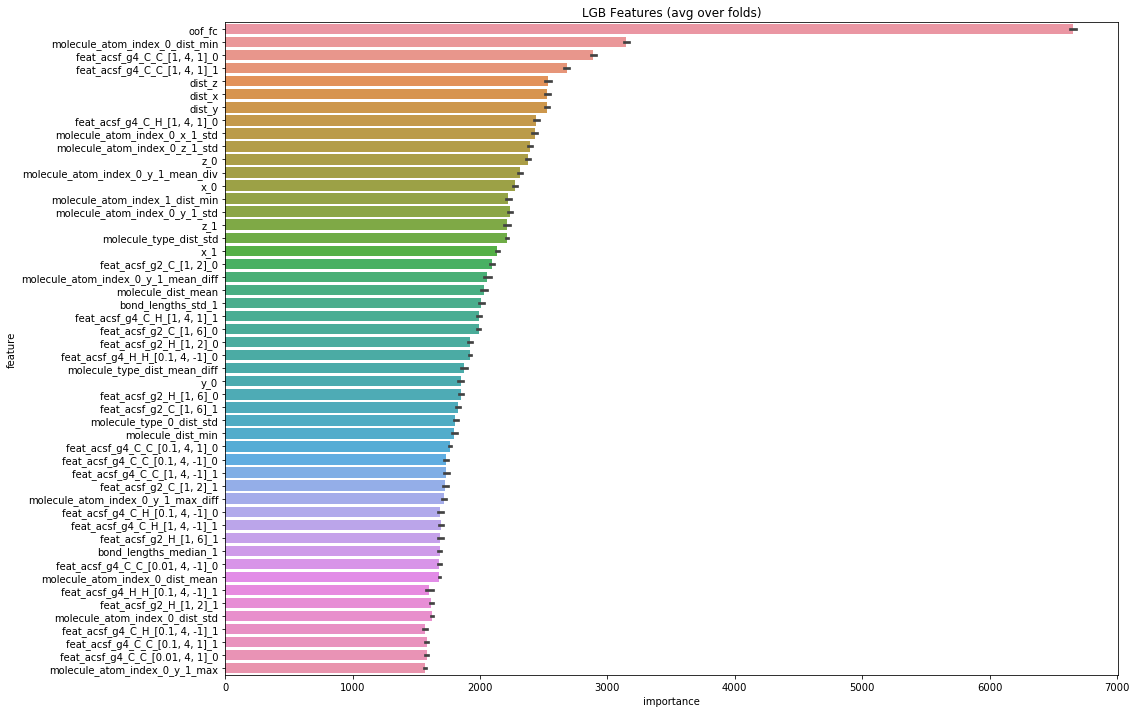

In [6]:
params = {'num_leaves': 160,
          'min_data_in_leaf': 100,
          'objective': 'regression', 
          'max_depth': 9,
          'learning_rate': 0.3,
          "boosting_type": "gbdt",
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "feature_fraction": 0.9,
          "feature_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'lambda_l1': 0.4,
          'lambda_l2': 0.2,
}
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', 
                                          eval_metric='group_mae', plot_feature_importance=True, verbose=500, 
                                          early_stopping_rounds=200, n_estimators=n_estimators_default)


In [ ]:
# L2 regressoin loss, CV mean score: -1.2278, std: 0.0019.
# L1 regression loss, CV mean score: -1.1743, std: 0.0028.

### Features sorted by importance

In [7]:
feature_importance = result_dict_lgb2['feature_importance']

sorted_features = feature_importance[['feature','importance']].groupby(['feature']).mean().sort_values(
        by='importance',ascending=False).index.tolist()

#sorted_features

In [8]:
feats = feature_importance[['feature','importance']].groupby(['feature']).mean().sort_values(
        by='importance',ascending=False)

In [9]:
len(feats), len(feats[feats.importance > 0]), len(feats[feats.importance > 1.5])

(338, 326, 310)

In [10]:
feats.to_csv('data/dataframes/feature_importance2.csv')

<a id="id6"></a> <br> 
# **6. Final Model** 

In [10]:
n_estimators_default = 5000

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Training models for each type

In [11]:
X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 2407.76 Mb (3.7% reduction)
Mem. usage decreased to 1295.09 Mb (3.7% reduction)


In [12]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})

In [13]:
avg_stdev = get_avg_stdev(X_short)

avg standard deviation: 6.183423224639669


In [14]:
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']

    stdev = X_short.loc[X_short['type'] == t].std()['target'] 
    print(f'standard deviation: {stdev}')
    variance = (stdev - avg_stdev)
    factor = np.tanh(variance/30)+1
    print(f'factor for model complexity: {factor}')
    
    depth_adjust = int(np.round((stdev - avg_stdev) / avg_stdev))
    print(f'max_depth adjustment: {depth_adjust}')

    num_leaves = int(np.round(160 * factor))
    print(f'number of leaves: {num_leaves}')
    
    min_data_in_leaf = int(np.round(100 * factor))
    print(f'minimum data to spawn leave: {min_data_in_leaf}')

    params = {'num_leaves': num_leaves,
          'min_data_in_leaf': min_data_in_leaf,
          'objective': 'regression', 
          'max_depth': 9 + depth_adjust,
          'learning_rate': 0.3,
          "boosting_type": "gbdt",
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "feature_fraction": 0.9,
          "feature_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'lambda_l1': 0.4,
          'lambda_l2': 0.2,
    }
    
    result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, 
                                              model_type='lgb', eval_metric='group_mae', plot_feature_importance=False, 
                                              verbose=500, early_stopping_rounds=500, n_estimators=n_estimators_default)
    
    #X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb3['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb3['prediction']

Training of type 0
standard deviation: 18.277236880290022
factor for model complexity: 1.382621464966523
max_depth adjustment: 2
number of leaves: 221
minimum data to spawn leave: 138
Fold 1 started at Thu Jul 11 11:53:40 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.465286	valid_1's l1: 0.721956
[1000]	training's l1: 0.308687	valid_1's l1: 0.711266
[1500]	training's l1: 0.2142	valid_1's l1: 0.705552
[2000]	training's l1: 0.153444	valid_1's l1: 0.702497
[2500]	training's l1: 0.111403	valid_1's l1: 0.70019
[3000]	training's l1: 0.0821217	valid_1's l1: 0.698916
[3500]	training's l1: 0.0611848	valid_1's l1: 0.698087
[4000]	training's l1: 0.0460904	valid_1's l1: 0.697487
[4500]	training's l1: 0.0352087	valid_1's l1: 0.696994
[5000]	training's l1: 0.0271831	valid_1's l1: 0.696695
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0271831	valid_1's l1: 0.696695
Fold 2 started at Thu Jul 11 12:09:33 2019
Training until validati

Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.118883	valid_1's l1: 0.39906
[1000]	training's l1: 0.0266743	valid_1's l1: 0.395119
[1500]	training's l1: 0.00866074	valid_1's l1: 0.394713
[2000]	training's l1: 0.00553617	valid_1's l1: 0.394595
[2500]	training's l1: 0.00435979	valid_1's l1: 0.394543
[3000]	training's l1: 0.00373144	valid_1's l1: 0.394488
[3500]	training's l1: 0.00333171	valid_1's l1: 0.394474
[4000]	training's l1: 0.0030488	valid_1's l1: 0.394468
[4500]	training's l1: 0.00283502	valid_1's l1: 0.39445
[5000]	training's l1: 0.00265939	valid_1's l1: 0.394447
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00265939	valid_1's l1: 0.394447
Fold 2 started at Thu Jul 11 14:00:04 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.110895	valid_1's l1: 0.402642
[1000]	training's l1: 0.0249124	valid_1's l1: 0.399885
[1500]	training's l1: 0.00838828	valid_1's l1: 0.399844
Early stop

Fold 2 started at Thu Jul 11 14:32:51 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.259571	valid_1's l1: 0.322195
[1000]	training's l1: 0.206531	valid_1's l1: 0.316199
[1500]	training's l1: 0.167565	valid_1's l1: 0.311865
[2000]	training's l1: 0.138262	valid_1's l1: 0.308503
[2500]	training's l1: 0.115532	valid_1's l1: 0.306031
[3000]	training's l1: 0.0975731	valid_1's l1: 0.304088
[3500]	training's l1: 0.0830225	valid_1's l1: 0.302872
[4000]	training's l1: 0.0710897	valid_1's l1: 0.301794
[4500]	training's l1: 0.0613001	valid_1's l1: 0.301009
[5000]	training's l1: 0.0531668	valid_1's l1: 0.300455
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0531668	valid_1's l1: 0.300455
Fold 3 started at Thu Jul 11 14:50:15 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.258386	valid_1's l1: 0.322937
[1000]	training's l1: 0.206016	valid_1's l1: 0.317375
[1500]	training's l1: 0.166905	val

[2000]	training's l1: 0.227197	valid_1's l1: 0.38761
[2500]	training's l1: 0.198972	valid_1's l1: 0.383456
[3000]	training's l1: 0.175618	valid_1's l1: 0.380586
[3500]	training's l1: 0.155407	valid_1's l1: 0.37788
[4000]	training's l1: 0.138287	valid_1's l1: 0.375795
[4500]	training's l1: 0.123379	valid_1's l1: 0.374356
[5000]	training's l1: 0.110582	valid_1's l1: 0.373052
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.110582	valid_1's l1: 0.373052
Fold 3 started at Thu Jul 11 17:24:29 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 0.354928	valid_1's l1: 0.407303
[1000]	training's l1: 0.303378	valid_1's l1: 0.398942
[1500]	training's l1: 0.26091	valid_1's l1: 0.391676
[2000]	training's l1: 0.2268	valid_1's l1: 0.386691
[2500]	training's l1: 0.19837	valid_1's l1: 0.382724
[3000]	training's l1: 0.174977	valid_1's l1: 0.379574
[3500]	training's l1: 0.155071	valid_1's l1: 0.376933
[4000]	training's l1: 0.137966	valid_1's l1

### scores for l2 regression

with lambda_l1 = 0.1 and lambda_l2 = 0.3

- CV mean score: -0.4101, std: 0.0009.
- CV mean score: -1.7386, std: 0.0032.
- CV mean score: -0.9993, std: 0.0088.
- CV mean score: -1.6426, std: 0.0079.
- CV mean score: -1.2682, std: 0.0029.
- CV mean score: -1.5983, std: 0.0076.
- CV mean score: -1.0264, std: 0.0039.
- CV mean score: -1.8335, std: 0.0189.

local CV: -1.314625
LB score: -1.584

### best mae/l1 regression score

lambda_l1 = 0.1, lambda_l2 = 0.3, factor = np.tanh(variance/20)+1

- CV mean score: -0.3981, std: 0.0016.
- CV mean score: -1.7055, std: 0.0036.
- CV mean score: -0.9291, std: 0.0092.
- CV mean score: -1.6048, std: 0.0103.
- CV mean score: -1.2033, std: 0.0021.
- CV mean score: -1.5529, std: 0.0051.
- CV mean score: -0.9857, std: 0.0026.
- CV mean score: -1.8029, std: 0.0085.

local CV: -1.30205
LB score: -1.611

### l1 regression with different params

lambda_l1 = 0.4, lambda_l2 = 0.2, factor = np.tanh(variance/30)+1

- CV mean score: -0.3631, std: 0.0034.
- CV mean score: -1.4712, std: 0.0041.
- CV mean score: -0.8201, std: 0.0062.
- CV mean score: -1.3792, std: 0.0113.
- CV mean score: -1.0056, std: 0.0051.
- CV mean score: -1.2725, std: 0.0032.
- CV mean score: -0.7200, std: 0.0030.
- CV mean score: -1.6033, std: 0.0082.

local CV: -1.2727875
LB score: -1.582

### l1 regression without oof fc

- CV mean score: -0.2321, std: 0.0012.
- CV mean score: -1.4712, std: 0.0041.
- CV mean score: -0.8201, std: 0.0062.
- CV mean score: -1.3792, std: 0.0113.
- CV mean score: -1.0056, std: 0.0051.
- CV mean score: -1.2725, std: 0.0032.
- CV mean score: -0.7200, std: 0.0030.
- CV mean score: -1.6033, std: 0.0082.

local CV: -1.30205
LB score: -1.063

In [16]:
scores_l2 = [-0.4101, -1.7386, -0.9993, -1.6426, -1.2682, -1.5983, -1.0264, -1.8335]

In [30]:
np.average(scores_l2)

-1.314625

In [15]:
scores_l1 = np.array([-0.3981, -1.7340, -0.9592, -1.6753, -1.2392, -1.5855, -1.0150, -1.8101])

In [16]:
np.average(scores_l1)

-1.30205

In [13]:
scores_l1_without_fc = [-0.2321, -1.4712, -0.8201, -1.3792, -1.0056, -1.2725, -0.7200, -1.6033]

In [14]:
np.average(scores_l1_without_fc)

-1.063

In [17]:
scores_l1_different_params = [-0.3981, -1.7055, -0.9291, -1.6048, -1.2033, -1.5529, -0.9857, -1.8029]

In [18]:
np.average(scores_l1_different_params)

-1.2727875

<a id="id7"></a> <br> 
# **7. Submission** 

In [15]:
sub = pd.read_csv('data/sample_submission.csv')
print('Sub dataset shape is  -> rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))

Sub dataset shape is  -> rows: 2505542 cols:2


In [16]:
#Training models for type
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('submission_type_l1_different_lambda.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,16.566084964905791
1,4658148,197.012498765292094
2,4658149,5.221423611748865
3,4658150,190.912647629581073
4,4658151,16.827828970461830


<a id="ref"></a> <br> 
# **8. References** 

[1] OOF Model: https://www.kaggle.com/adarshchavakula/out-of-fold-oof-model-cross-validation<br>
[2] Using Meta Features: https://www.kaggle.com/artgor/using-meta-features-to-improve-model<br>
[3] Lot of Features: https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b <br>
[4] Angle Feature: https://www.kaggle.com/kmat2019/effective-feature <br>
[5] Recovering bonds from structure: https://www.kaggle.com/aekoch95/bonds-from-structure-data <br>